In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

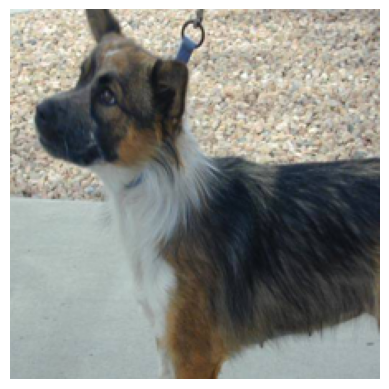

In [2]:
image_path = 'train/dog.3.jpg' 
image = Image.open(image_path)

# Resize the image
resized_image = image.resize((224, 224))

# If the image is not in RGB mode, convert it to RGB
if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

# Convert the resized image to a numpy array
image_array = np.array(resized_image)

# Display the resized image
plt.imshow(image_array)
plt.axis('off')
plt.show()


In [3]:
dogs_num = 12499
cats_num = 12499
image_size = (224, 224)
train_dir = 'train'
validation_split = 0.2

# Function to load and process images
def load_image(image_path):
    image = Image.open(image_path)
    resized_image = image.resize(image_size)
    if resized_image.mode != 'RGB':
        resized_image = resized_image.convert('RGB')
    image_array = np.array(resized_image)
    return image_array

# Function to create dataset
def create_dataset(dir_path, dogs_num, cats_num):
    data = []
    labels = []
    
    for i in range(dogs_num):
        image_path = os.path.join(dir_path, f'dog.{i}.jpg')
        image_array = load_image(image_path)
        label = np.array([[1, 0]])  # Dog label
        data.append((image_array, label))
        
    for i in range(cats_num):
        image_path = os.path.join(dir_path, f'cat.{i}.jpg')
        image_array = load_image(image_path)
        label = np.array([[0, 1]])  # Cat label
        data.append((image_array, label))
    
    return data

# Load training data
train_data = create_dataset(train_dir, dogs_num, cats_num)

# Shuffle data
np.random.shuffle(train_data)

# Manually split into training and validation sets
split_index = int(len(train_data) * (1 - validation_split))
train_set = train_data[:split_index]
val_set = train_data[split_index:]

# Example of accessing data
print(f'Training set size: {len(train_set)}')
print(f'Validation set size: {len(val_set)}')

# Example: Access an image and label from the training set
example_image, example_label = train_set[0]
print(f'Example image shape: {example_image.shape}')
print(f'Example label: {example_label}')


Training set size: 19998
Validation set size: 5000
Example image shape: (224, 224, 3)
Example label: [[1 0]]


(224, 224, 3)


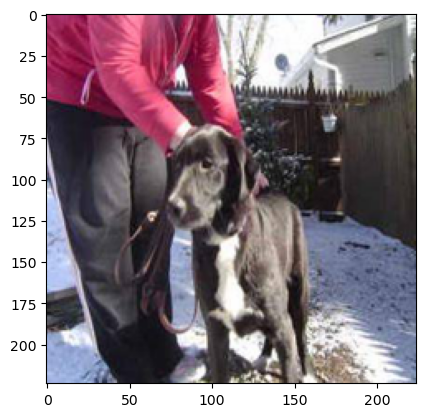

In [4]:
plt.imshow(train_set[4][0])
print(train_set[4][0].shape)

In [6]:
# Setting up functions in forward propogation
# We will forward propogate one piece of data at a time, then average over the examples, to simulate batches
def batch_norm_forward(x, gamma, beta, eps=1e-5):
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0) # std_dev ** 2
    x_normalized = (x - mean) / np.sqrt(variance + eps)
    # gamma and beta are learned
    out = gamma * x_normalized + beta
    cache = (x, x_normalized, mean, variance, gamma, beta, eps)
    return out, cache


def batch_norm_backward(dout, cache):
    x, x_normalized, mean, variance, gamma, beta, eps = cache
    N = x.shape[0]
    
    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_normalized, axis=0)
    
    dx_normalized = dout * gamma
    dvariance = np.sum(dx_normalized * (x - mean) * -0.5 * np.power(variance + eps, -1.5), axis=0)
    dmean = np.sum(dx_normalized * -1 / np.sqrt(variance + eps), axis=0) + dvariance * np.sum(-2 * (x - mean), axis=0) / N
    
    dx = dx_normalized / np.sqrt(variance + eps) + dvariance * 2 * (x - mean) / N + dmean / N
    return dx, dgamma, dbeta



def max_pooling(input_data, output_data):
    input_height, input_width, input_depth = input_data.shape

    # Calculate the output dimensions
    output_height = input_height // 2 
    output_width = input_width // 2
    output_depth = input_depth

    # Initialize the output array and array to store indices
    output_data = np.zeros((output_height, output_width, output_depth))
    indices = np.zeros((output_height, output_width, output_depth, 2), dtype=int)

    # Apply max pooling
    for h in range(output_height):
        for w in range(output_width):
            for d in range(output_depth):
                # Extract the 2x2 region of interest from the input data
                region = input_data[h*2:(h+1)*2, w*2:(w+1)*2, d]
                # Compute the maximum value in the region
                max_val = np.max(region)
                output_data[h, w, d] = max_val
                # Find the indices of the maximum value in the region
                max_indices = np.unravel_index(np.argmax(region), region.shape)
                # Store the indices relative to the region and convert to global indices
                indices[h, w, d] = [h*2 + max_indices[0], w*2 + max_indices[1]]

    return output_data, indices


def correlate(input_image, kernel):
    # Dimensions of the input and kernel
    input_height, input_width, input_channels = input_image.shape
    filter_height, filter_width, filter_channels, num_filters = kernel.shape
    
    # Output dimensions
    output_height = input_height - filter_height + 1 # (H - S + 1)
    output_width = input_width - filter_width + 1 # (W - S + 1)

    # Initialize the output
    output = np.zeros((output_height, output_width, num_filters))
    
    # Loop through each filter
    for filter in range(num_filters):
        # Loop through height and width of the output
        for i in range(output_height):
            for j in range(output_width):
                # Extract the patch from the input image
                input_patch = input_image[i:i+filter_height, j:j+filter_width, :]
                # Perform the correlation operation
                output[i, j, filter] = np.sum(input_patch * kernel[:, :, :, filter]) 
    return output


def convolve(input_image, kernel):
    # Dimensions of the input and kernel
    input_height, input_width, input_channels = input_image.shape
    filter_height, filter_width, filter_channels, num_filters = kernel.shape
    
    # Padding size (pad_height and pad_width are half the kernel size, rounded down)
    pad_height = filter_height - 1
    pad_width = filter_width - 1
    
    # Output dimensions
    output_height = input_height + pad_height # 7
    output_width = input_width + pad_width # 7

    # Initialize the output
    output = np.zeros((output_height, output_width, num_filters))
    
    # Pad the input image with zeros
    padded_input = np.pad(input_image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    
    # Flip kernel horizontally and vertically
    rotated_kernel = np.flip(kernel, axis=(0, 1))
    
    # Loop through each filter
    for filter in range(num_filters):
        # Loop through the height and width of the output
        for i in range(output_height):
            for j in range(output_width):
                # Extract the patch from the padded input image
                input_patch = padded_input[i:i+filter_height, j:j+filter_width, :]
                # Perform the convolution operation
                output[i, j, filter] = np.sum(input_patch * rotated_kernel[:, :, :, filter])
    return output


def der_ReLU(Z):
  return Z > 0

def ReLU2(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def ReLU(Z): # Takes in a scalar, returns a scalar
    return np.maximum(Z, 0)

def ReLU2(Z): # Takes in a scalar, returns a scalar
    return np.maximum(Z, 0)

def sigmoid_prime(z):
  return sigmoid(z)*(1-sigmoid(z))

def sigmoid(z):
    # Compute the sigmoid function element-wise
    return 1.0 / (1.0 + np.exp(-z))

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    sum_exp_Z = np.sum(exp_Z, axis=1, keepdims=True)
    return exp_Z / sum_exp_Z


In [9]:
# Define parameters
# Convolutional layer -> ReLU activation -> Batch normalization -> Dropout -> Max pooling

# Layer 1
conv1_1_kernel = np.random.randn(3, 3, 3, 64)
conv1_1_bias = np.zeros((222, 222, 64))
layer1_1_output = np.zeros((222, 222, 64))

conv1_2_kernel = np.random.randn(3, 3, 64, 64)
conv1_2_bias = np.zeros((220, 220, 64))
layer1_2_output = np.zeros((220, 220, 64))

gamma1_conv = np.ones((220, 220, 64))
beta1_conv = np.zeros((220, 220, 64))

layer1_pool = np.zeros((110, 110, 64))

# Layer 2
conv2_1_kernel = np.random.randn(3, 3, 64, 128)
conv2_1_bias = np.zeros((108, 108, 128))
layer2_1_output = np.zeros((108, 108, 128))

conv2_2_kernel = np.random.randn(3, 3, 128, 128)
conv2_2_bias = np.zeros((106, 106, 128))
layer2_2_output = np.zeros((106, 106, 128))

conv2_3_kernel = np.random.randn(3, 3, 128, 128)
conv2_3_bias = np.zeros((104, 104, 128))
layer2_3_output = np.zeros((104, 104, 128))

gamma2_conv = np.ones((104, 104, 128))
beta2_conv = np.zeros((104, 104, 128))

layer2_pool = np.zeros((52, 52, 128))

# Layer 3
conv3_1_kernel = np.random.randn(3, 3, 128, 256)
conv3_1_bias = np.zeros((50, 50, 256))
layer3_1_output = np.zeros((50, 50, 256))

conv3_2_kernel = np.random.randn(3, 3, 256, 256)
conv3_2_bias = np.zeros((48, 48, 256))
layer3_2_output = np.zeros((48, 48, 256))

gamma3_conv = np.ones((48, 48, 256))
beta3_conv = np.zeros((48, 48, 256))

layer3_pool = np.zeros((24, 24, 256))

# Layer 4
conv4_1_kernel = np.random.randn(3, 3, 256, 512)
conv4_1_bias = np.zeros((22, 22, 512))
layer4_1_output = np.zeros((22, 22, 512))

conv4_2_kernel = np.random.randn(3, 3, 512, 512)
conv4_2_bias = np.zeros((20, 20, 512))
layer4_2_output = np.zeros((20, 20, 512))

conv4_3_kernel = np.random.randn(3, 3, 512, 512)
conv4_3_bias = np.zeros((18, 18, 512))
layer4_3_output = np.zeros((18, 18, 512))

gamma4_conv = np.ones((18, 18, 512))
beta4_conv = np.zeros((18, 18, 512))

layer4_pool = np.zeros((9, 9, 512))

# Layer 5
conv5_1_kernel = np.random.randn(3, 3, 512, 512)
conv5_1_bias = np.zeros((7, 7, 512))
layer5_1_output = np.zeros((7, 7, 512))

conv5_2_kernel = np.random.randn(3, 3, 512, 512) # eg.  (7, 7, 512) * (5, 5, i) -> (3, 3, i)
conv5_2_bias = np.zeros((5, 5, 512))
# Each layer output is a filter output
layer5_2_output = np.zeros((5, 5, 512))

gamma5_conv = np.ones((5, 5, 512))
beta5_conv = np.zeros((5, 5, 512))

# Layer 6
fc1_weights = np.random.randn(12800, 4096)
fc1_bias = np.zeros((1, 4096))
layer6_1_output = np.zeros((1, 4096))

fc2_weights = np.random.randn(4096, 2)
fc2_bias = np.zeros((1,2))
layer6_2_output = np.zeros((1, 2))

In [10]:
# Forward propogation
# Convolutional layer -> ReLU activation -> Batch normalization -> Dropout -> Max pooling
def forward_propogation(
    layer_input, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool,
    conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool,
    conv3_1_kernel, conv3_1_bias,layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv,beta3_conv, layer3_pool,
    conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output ,conv4_3_kernel ,conv4_3_bias,layer4_3_output, gamma4_conv ,beta4_conv, layer4_pool,
    conv5_1_kernel ,conv5_1_bias,layer5_1_output, conv5_2_kernel ,conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, 
    fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output, dropout_rate = 0.25):
    
    # Layer 1
    layer1_1_output = correlate(layer_input, conv1_1_kernel)
    layer1_1_output += conv1_1_bias
    layer1_1_output = ReLU(layer1_1_output)
    
    layer1_2_output = correlate(layer1_1_output, conv1_2_kernel)
    layer1_2_output += conv1_2_bias
    layer1_2_output = ReLU(layer1_2_output)

    layer1_2_output, layer1_cache = batch_norm_forward(layer1_2_output, gamma1_conv, beta1_conv)
    
    dropout1_mask = (np.random.rand(*layer1_2_output.shape) < dropout_rate) / dropout_rate   # Matrix of random values between 0 and 1 -> binary 0 and 1 after comparision. We scale by 1 / dropout_rate, so that the CNN's activation after dropout stay relatively the same
    layer1_2_output *= dropout1_mask

    layer1_pool, layer1_indices = max_pooling(layer1_2_output, layer1_pool)
    print("here1")

    # Layer 2
    layer2_1_output = correlate(layer1_pool, conv2_1_kernel)
    layer2_1_output += conv2_1_bias
    layer2_1_output = ReLU(layer2_1_output)
    
    layer2_2_output = correlate(layer2_1_output, conv2_2_kernel)
    layer2_2_output += conv2_2_bias
    layer2_2_output = ReLU(layer2_2_output)

    layer2_3_output = correlate(layer2_2_output, conv2_3_kernel)
    layer2_3_output += conv2_3_bias
    layer2_3_output = ReLU(layer2_3_output)

    layer2_3_output, layer2_cache = batch_norm_forward(layer2_3_output, gamma2_conv, beta2_conv)
    
    dropout2_mask = (np.random.rand(*layer2_3_output.shape) < dropout_rate) / dropout_rate 
    layer2_3_output *= dropout2_mask

    layer2_pool, layer2_indices = max_pooling(layer2_3_output, layer2_pool)
    print("here2")

    # Layer 3
    layer3_1_output = correlate(layer2_pool, conv3_1_kernel)
    layer3_1_output += conv3_1_bias
    layer3_1_output = ReLU(layer3_1_output)
    
    layer3_2_output = correlate(layer3_1_output, conv3_2_kernel)
    layer3_2_output += conv3_2_bias
    layer3_2_output = ReLU(layer3_2_output)

    layer3_2_output, layer3_cache = batch_norm_forward(layer3_2_output, gamma3_conv, beta3_conv)
    
    dropout3_mask = (np.random.rand(*layer3_2_output.shape) < dropout_rate) / dropout_rate   # Matrix of random values between 0 and 1 -> binary 0 and 1 after comparision. We scale by 1 / dropout_rate, so that the CNN's activation after dropout stay relatively the same
    layer3_2_output *= dropout3_mask

    layer3_pool, layer3_indices = max_pooling(layer3_2_output, layer3_pool)
    print("here3")

    # Layer 4
    layer4_1_output = correlate(layer3_pool, conv4_1_kernel)
    layer4_1_output += conv4_1_bias
    layer4_1_output = ReLU(layer4_1_output)
    
    layer4_2_output = correlate(layer4_1_output, conv4_2_kernel)
    layer4_2_output += conv4_2_bias
    layer4_2_output = ReLU(layer4_2_output)

    layer4_3_output = correlate(layer4_2_output, conv4_3_kernel)
    layer4_3_output += conv4_3_bias
    layer4_3_output = ReLU(layer4_3_output)

    layer4_3_output, layer4_cache = batch_norm_forward(layer4_3_output, gamma4_conv, beta4_conv)
    
    dropout4_mask = (np.random.rand(*layer4_3_output.shape) < dropout_rate) / dropout_rate 
    layer4_3_output *= dropout4_mask

    layer4_pool, layer4_indices = max_pooling(layer4_3_output, layer4_pool)
    print("here4")
    
    # Layer 5
    layer5_1_output = correlate(layer4_pool, conv5_1_kernel)
    layer5_1_output += conv5_1_bias
    layer5_1_output = ReLU(layer5_1_output)
    
    layer5_2_output = correlate(layer5_1_output, conv5_2_kernel)
    layer5_2_output += conv5_2_bias
    layer5_2_output = ReLU(layer5_2_output)

    layer5_2_output, layer5_cache = batch_norm_forward(layer5_2_output, gamma5_conv, beta5_conv)
    
    dropout5_mask = (np.random.rand(*layer5_2_output.shape) < dropout_rate) / dropout_rate   # Matrix of random values between 0 and 1 -> binary 0 and 1 after comparision. We scale by 1 / dropout_rate, so that the CNN's activation after dropout stay relatively the same
    
    layer5_2_output *= dropout5_mask
    print("here5")
        
    # Layer 6
    layer6_1_output = (layer5_2_output.reshape(1, 12800)) @ fc1_weights
    layer6_1_output +=fc1_bias

    layer6_1_output = ReLU(layer6_1_output)
    
    layer6_2_output = layer6_1_output @ fc2_weights
    layer6_2_output += fc2_bias
    print(layer6_2_output)
    layer6_2_output = softmax(layer6_2_output)
    print(layer6_2_output)
    
    return (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask, layer4_indices, layer4_cache, dropout4_mask, layer5_cache, dropout5_mask)
        

In [24]:
# Backpropogation
# dog = 0, cat = 1. Define first option as dog, second as cat. Can only be [0,1] or [1,0]
# As a tuple, define one training example as a (numpy_array, [1,0]..) tuple
def backward_pass(layer_input, label, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool, layer1_indices, layer1_cache, dropout1_mask, 
            conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool, layer2_indices, layer2_cache, dropout2_mask,
            conv3_1_kernel, conv3_1_bias, layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv, beta3_conv, layer3_pool, layer3_indices, layer3_cache, dropout3_mask,
            conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output, conv4_3_kernel, conv4_3_bias, layer4_3_output, gamma4_conv, beta4_conv, layer4_pool, layer4_indices, layer4_cache, dropout4_mask,
            conv5_1_kernel, conv5_1_bias, layer5_1_output, conv5_2_kernel, conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, layer5_cache, dropout5_mask,
            fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output):
    
    print("starting backprop")
    dconv5_2_kernel = np.zeros_like(conv5_2_kernel)
    dlayer5_2_output =np.zeros_like(layer5_2_output)
    
    dconv5_1_kernel = np.zeros_like(conv5_1_kernel)
    dlayer5_1_output = np.zeros_like(layer5_1_output)
    
    dlayer4_pool = np.zeros_like(layer4_pool)

    dconv4_1_kernel = np.zeros_like(conv4_1_kernel)
    dlayer4_1_output = np.zeros_like(layer4_1_output)
    
    dconv4_2_kernel = np.zeros_like(conv4_2_kernel)
    dlayer4_2_output = np.zeros_like(layer4_2_output)
    
    dconv4_3_kernel = np.zeros_like(conv4_3_kernel)
    dlayer4_3_output = np.zeros_like(layer4_3_output)

    dlayer3_pool = np.zeros_like(layer3_pool)

    dconv3_2_kernel = np.zeros_like(conv3_2_kernel)
    dlayer3_2_output =np.zeros_like(layer3_2_output)
    
    dconv3_1_kernel = np.zeros_like(conv3_1_kernel)
    dlayer3_1_output = np.zeros_like(layer3_1_output)
    
    dlayer2_pool = np.zeros_like(layer2_pool)

    dconv2_1_kernel = np.zeros_like(conv2_1_kernel)
    dlayer2_1_output = np.zeros_like(layer2_1_output)
    
    dconv2_2_kernel = np.zeros_like(conv2_2_kernel)
    dlayer2_2_output = np.zeros_like(layer2_2_output)
    
    dconv2_3_kernel = np.zeros_like(conv2_3_kernel)
    dlayer2_3_output = np.zeros_like(layer2_3_output)

    dlayer1_pool = np.zeros_like(layer1_pool)

    dconv1_2_kernel = np.zeros_like(conv1_2_kernel)
    dlayer1_2_output =np.zeros_like(layer1_2_output)
    
    dconv1_1_kernel = np.zeros_like(conv1_1_kernel)
    dlayer1_1_output = np.zeros_like(layer1_1_output)

    
    ### Layer 6 ----------------------------------------------------------------------------------------------------------------------------------------
    # Layer 6 - Softmax
    dlayer6_2_output = layer6_2_output - label # (1,2)
    
    # fc2
    dfc2_bias = dlayer6_2_output # (1,2)
    
    dfc2_weights = layer6_1_output.T @ dlayer6_2_output # (4096, 1) @ (1, 2) = (4096, 2)
    
    dlayer6_1_output = (dlayer6_2_output @ fc2_weights.T) * der_ReLU(layer6_1_output) # (1, 2) @ (2, 4096) = (1, 4096)
    
    # fc1
    dfc1_bias = dlayer6_1_output
    
    dfc1_weights = (layer5_2_output.reshape(1, 12800).T) @ dlayer6_1_output # (12800, 1) @ (1, 4096) = (12800, 4096)
    
    dlayer5_2_output = (dlayer6_1_output @ fc1_weights.T) # (1, 4096) @ (4096, 12800) = (1, 12800)

    
    ### Layer 5 ----------------------------------------------------------------------------------------------------------------------------------------
    # Unflatten
    dlayer5_2_output = dlayer5_2_output.reshape(5, 5, 512)

    # Layer 5 - Dropout
    dlayer5_2_output *= dropout5_mask
    
    # Layer 5 - Batch norm
    dlayer5_2_output, dgamma5_conv, dbeta5_conv = batch_norm_backward(dlayer5_2_output, layer5_cache)

    # Layer 5 - conv2
    dlayer5_2_output *= der_ReLU(layer5_2_output) # (5,5,512)
    dconv5_2_bias = dlayer5_2_output # (5,5,512)

    # Looping over filters
    for filter in range(conv5_2_kernel.shape[3]): # 512
        temp2 = dlayer5_2_output[:, :, filter].reshape((dlayer5_2_output.shape[0], dlayer5_2_output.shape[0], 1, 1))
        for slice in range(conv5_2_kernel.shape[2]): # 512
            temp1 = layer5_1_output[:, :, slice].reshape((layer5_1_output.shape[0], layer5_1_output.shape[0], 1))
            dconv5_2_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,512,512)
    print('done1')
    
    for filter in range(conv5_2_kernel.shape[3]): # 512
        temp1 = dlayer5_2_output[:, :, filter].reshape((dlayer5_2_output.shape[0], dlayer5_2_output.shape[0], 1))
        for slice in range(conv5_2_kernel.shape[2]): # 512
            temp2 = conv5_2_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer5_1_output += convolve(temp1, temp2)
    print('done2')
    
     # Layer 5 - BP conv1
    dlayer5_1_output *= der_ReLU(layer5_1_output) # (7,7,512)
    dconv5_1_bias = dlayer5_1_output # (7,7,512)
    
    
    # Looping over filters
    for filter in range(conv5_1_kernel.shape[3]): # 512
        temp2 = dlayer5_1_output[:, :, filter].reshape((dlayer5_1_output.shape[0], dlayer5_1_output.shape[0], 1, 1))
        for slice in range(conv5_1_kernel.shape[2]): # 512
            temp1 = layer4_pool[:, :, slice].reshape((layer4_pool.shape[0], layer4_pool.shape[0], 1))
            dconv5_1_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,512,512)
    print('done1')
    
    for filter in range(conv5_1_kernel.shape[3]): # 512
        temp1 = dlayer5_1_output[:, :, filter].reshape((dlayer5_1_output.shape[0], dlayer5_1_output.shape[0], 1))
        for slice in range(conv5_1_kernel.shape[2]): # 512
            temp2 = conv5_1_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            layer4_pool += convolve(temp1, temp2)
    print('done2')

    ### Layer 4 ----------------------------------------------------------------------------------------------------------------------------------------
    
    # Unpooling - (9, 9, 512) -> (18, 18, 512)
    for i in range(dlayer4_pool.shape[0]):  # 9
        for j in range(dlayer4_pool.shape[1]):  # 9
            for k in range(dlayer4_pool.shape[2]): # 512
                # Get the global indices from layer_indices
                x_index, y_index = layer4_indices[i, j, k] # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer4_3_output[x_index, y_index, k] = dlayer4_pool[i, j, k]
    
    # Layer 4 - Dropout
    dlayer4_3_output *= dropout4_mask
    
    # Layer 4 - Batch norm
    dlayer4_3_output, dgamma4_conv, dbeta4_conv = batch_norm_backward(dlayer4_3_output, layer4_cache)

    # Layer 4 - BP conv3
    dlayer4_3_output *= der_ReLU(layer4_3_output) # (18,18,512)
    dconv4_3_bias = dlayer4_3_output # (18,18,512)

    # Looping over filters
    for filter in range(conv4_3_kernel.shape[3]): # 512
        temp2 = dlayer4_3_output[:, :, filter].reshape((dlayer4_3_output.shape[0], dlayer4_3_output.shape[0], 1, 1))
        for slice in range(conv4_3_kernel.shape[2]): # 512
            temp1 = layer4_2_output[:, :, slice].reshape((layer4_2_output.shape[0], layer4_2_output.shape[0], 1))
            dconv4_3_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,512,512)
    print('done1')
    
    for filter in range(conv4_3_kernel.shape[3]): # 512
        temp1 = dlayer4_3_output[:, :, filter].reshape((dlayer4_3_output.shape[0], dlayer4_3_output.shape[0], 1))
        for slice in range(conv4_3_kernel.shape[2]): # 512
            temp2 = conv4_3_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer4_2_output += convolve(temp1, temp2)
    print('done2')
    
    # Layer 4 - BP conv2
    dlayer4_2_output *= der_ReLU(layer4_2_output) # (18,18,512)
    dconv4_2_bias = dlayer4_2_output # (18,18,512)

     # Looping over filters
    for filter in range(conv4_2_kernel.shape[3]): # 512
        temp2 = dlayer4_2_output[:, :, filter].reshape((dlayer4_2_output.shape[0], dlayer4_2_output.shape[0], 1, 1))
        for slice in range(conv4_2_kernel.shape[2]): # 512
            temp1 = layer4_1_output[:, :, slice].reshape((layer4_1_output.shape[0], layer4_1_output.shape[0], 1))
            dconv4_2_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,512,512)
    print('done1')
    
    for filter in range(conv4_2_kernel.shape[3]): # 512
        temp1 = dlayer4_2_output[:, :, filter].reshape((dlayer4_2_output.shape[0], dlayer4_2_output.shape[0], 1))
        for slice in range(conv4_2_kernel.shape[2]): # 512
            temp2 = conv4_2_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer4_1_output += convolve(temp1, temp2)
    print('done2')
    
    # Layer 4 - BP conv1
    dlayer4_1_output *= der_ReLU(layer4_1_output) # (18,18,512)
    dconv4_1_bias = dlayer4_1_output # (18,18,512)

    # Looping over filters
    for filter in range(conv4_1_kernel.shape[3]): # 512
        temp2 = dlayer4_1_output[:, :, filter].reshape((dlayer4_1_output.shape[0], dlayer4_1_output.shape[0], 1, 1))
        for slice in range(conv4_1_kernel.shape[2]): # 512
            temp1 = layer3_pool[:, :, slice].reshape((layer3_pool.shape[0], layer3_pool.shape[0], 1))
            dconv4_1_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,512,512)
    print('done1')
    
    for filter in range(conv4_1_kernel.shape[3]): # 512
        temp1 = dlayer4_1_output[:, :, filter].reshape((dlayer4_1_output.shape[0], dlayer4_1_output.shape[0], 1))
        for slice in range(conv4_1_kernel.shape[2]): # 512
            temp2 = conv4_1_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer3_pool += convolve(temp1, temp2)
    print('done2')


    ### Layer 3 ----------------------------------------------------------------------------------------------------------------------------------------
    
    # Unpooling - (24, 24, 256) -> (48, 48, 256)
    for i in range(dlayer3_pool.shape[0]):
        for j in range(dlayer3_pool.shape[1]): 
            for k in range(dlayer3_pool.shape[2]):
                # Get the global indices from layer_indices
                x_index, y_index = layer3_indices[i, j, k] # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer3_2_output[x_index, y_index, k] = dlayer3_pool[i, j, k]
    
    # Layer 3 - Dropout
    dlayer3_2_output *= dropout3_mask

    # Layer 3 - Batch norm
    dlayer3_2_output, dgamma3_conv, dbeta3_conv = batch_norm_backward(dlayer3_2_output, layer3_cache)

    # Layer 3 - BP conv2
    dlayer3_2_output *= der_ReLU(layer3_2_output) # (36,36,256)
    dconv3_2_bias = dlayer3_2_output # (36,36,256)


    # Looping over filters
    for filter in range(conv3_2_kernel.shape[3]): # 256
        temp2 = dlayer3_2_output[:, :, filter].reshape((dlayer3_2_output.shape[0], dlayer3_2_output.shape[0], 1, 1))
        for slice in range(conv3_2_kernel.shape[2]): # 256
            temp1 = layer3_1_output[:, :, slice].reshape((layer3_1_output.shape[0], layer3_1_output.shape[0], 1))
            dconv3_2_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,256,256)
    print('done1')

    for filter in range(conv3_2_kernel.shape[3]): # 256
        temp1 = dlayer3_2_output[:, :, filter].reshape((dlayer3_2_output.shape[0], dlayer3_2_output.shape[0], 1))
        for slice in range(conv3_2_kernel.shape[2]): # 256
            temp2 = conv3_2_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer3_1_output += convolve(temp1, temp2)
    print('done2')
    
    # Layer 3 - BP conv1
    dlayer3_1_output *= der_ReLU(layer3_1_output) # (36,36,256)
    dconv3_1_bias = dlayer3_1_output # (36,36,256)

    # Looping over filters
    for filter in range(conv3_1_kernel.shape[3]): # 256
        temp2 = dlayer3_1_output[:, :, filter].reshape((dlayer3_1_output.shape[0], dlayer3_1_output.shape[0], 1, 1))
        for slice in range(conv3_1_kernel.shape[2]): # 256
            temp1 = layer2_pool[:, :, slice].reshape((layer2_pool.shape[0], layer2_pool.shape[0], 1))
            dconv3_1_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,256,256)
    print('done1')

    for filter in range(conv3_1_kernel.shape[3]): # 256
        temp1 = dlayer3_1_output[:, :, filter].reshape((dlayer3_1_output.shape[0], dlayer3_1_output.shape[0], 1))
        for slice in range(conv3_1_kernel.shape[2]): # 256
            temp2 = conv3_1_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer2_pool += convolve(temp1, temp2)
    print('done2')

    ### Layer 2 ----------------------------------------------------------------------------------------------------------------------------------------
    # Unpooling - (24, 24, 256) -> (48, 48, 256)
    for i in range(dlayer2_pool.shape[0]):
        for j in range(dlayer2_pool.shape[1]): 
            for k in range(dlayer2_pool.shape[2]):
                # Get the global indices from layer_indices
                x_index, y_index = layer2_indices[i, j, k] # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer2_3_output[x_index, y_index, k] = dlayer2_pool[i, j, k]
    
    # Layer 2 - Dropout
    dlayer2_3_output *= dropout2_mask

    # Layer 2 - Batch norm
    dlayer2_3_output, dgamma2_conv, dbeta2_conv = batch_norm_backward(dlayer2_3_output, layer2_cache)

    # Layer 2 - BP conv3
    dlayer2_3_output *= der_ReLU(layer2_3_output) # (72,72,128)
    dconv2_3_bias = dlayer2_3_output # (72,72,128)

    # Looping over filters
    for filter in range(conv2_3_kernel.shape[3]): # 128
        temp2 = dlayer2_3_output[:, :, filter].reshape((dlayer2_3_output.shape[0], dlayer2_3_output.shape[0], 1, 1))
        for slice in range(conv2_3_kernel.shape[2]): # 128
            temp1 = layer2_2_output[:, :, slice].reshape((layer2_2_output.shape[0], layer2_2_output.shape[0], 1))
            dconv2_3_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,128,128)
    print('done1')

    for filter in range(conv2_3_kernel.shape[3]): # 128
        temp1 = dlayer2_3_output[:, :, filter].reshape((dlayer2_3_output.shape[0], dlayer2_3_output.shape[0], 1))
        for slice in range(conv2_3_kernel.shape[2]): # 128
            temp2 = conv2_3_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer2_2_output += convolve(temp1, temp2)
    print('done2')

    # Layer 2 - BP conv2
    dlayer2_2_output *= der_ReLU(layer2_2_output) # (72,72,128)
    dconv2_2_bias = dlayer2_2_output # (72,72,128)

    # Looping over filters
    for filter in range(conv2_2_kernel.shape[3]): # 128
        temp2 = dlayer2_2_output[:, :, filter].reshape((dlayer2_2_output.shape[0], dlayer2_2_output.shape[0], 1, 1))
        for slice in range(conv2_2_kernel.shape[2]): # 128
            temp1 = layer2_1_output[:, :, slice].reshape((layer2_1_output.shape[0], layer2_1_output.shape[0], 1))
            dconv2_2_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,128,128)
    print('done1')
    print("here")
    
    
    for filter in range(conv2_2_kernel.shape[3]): # 128
        temp1 = dlayer2_2_output[:, :, filter].reshape((dlayer2_2_output.shape[0], dlayer2_2_output.shape[0], 1))
        for slice in range (conv2_2_kernel.shape[2]): # 512
            # Broadcast the corresponding kernel to the input depth
            temp2 = conv2_2_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer2_1_output += convolve(temp1, temp2)
    print('done2')

    # Layer 2 - BP conv1
    dlayer2_1_output *= der_ReLU(layer2_1_output) # (72,72,128)
    dconv2_1_bias = dlayer2_1_output # (72,72,128)

    # Looping over filters
    for filter in range(conv2_1_kernel.shape[3]): # 128
        temp2 = dlayer2_1_output[:, :, filter].reshape((dlayer2_1_output.shape[0], dlayer2_1_output.shape[0], 1, 1))
        for slice in range(conv2_1_kernel.shape[2]): # 128
            temp1 = layer1_pool[:, :, slice].reshape((layer1_pool.shape[0], layer1_pool.shape[0], 1))
            dconv2_1_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,128,128)
    print('done1')

    for filter in range(conv2_1_kernel.shape[3]): # 128
        temp1 = dlayer2_1_output[:, :, filter].reshape((dlayer2_1_output.shape[0], dlayer2_1_output.shape[0], 1))
        for slice in range(conv2_1_kernel.shape[2]): # 128
            temp2 = conv2_1_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer1_pool += convolve(temp1, temp2)
    print('done2')
    

    ### Layer 1 ----------------------------------------------------------------------------------------------------------------------------------------
    
    # Unpooling - (110, 110, 64) -> (220, 220, 64)
    for i in range(dlayer1_pool.shape[0]):
        for j in range(dlayer1_pool.shape[1]): 
            for k in range(dlayer1_pool.shape[2]):
                # Get the global indices from layer_indices
                x_index, y_index = layer1_indices[i, j, k] # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer1_2_output[x_index, y_index, k] = dlayer1_pool[i, j, k]
    
    # Layer 3 - Dropout
    dlayer1_2_output *= dropout1_mask
    
    # Layer 3 - Batch norm
    dlayer1_2_output, dgamma1_conv, dbeta1_conv = batch_norm_backward(dlayer1_2_output, layer1_cache)

    # Layer 1 - BP conv2
    dlayer1_2_output *= der_ReLU(layer1_2_output) # (144,144,64)
    dconv1_2_bias = dlayer1_2_output # (144,144,64)

    # Looping over filters
    for filter in range(conv1_2_kernel.shape[3]): # 64
        temp2 = dlayer1_2_output[:, :, filter].reshape((dlayer1_2_output.shape[0], dlayer1_2_output.shape[0], 1, 1))
        for slice in range(conv1_2_kernel.shape[2]): # 64
            temp1 = layer1_1_output[:, :, slice].reshape((layer1_1_output.shape[0], layer1_1_output.shape[0], 1))
            dconv1_2_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,64,64)
    print('done1')

    for filter in range(conv1_2_kernel.shape[3]): # 64
        temp1 = dlayer1_2_output[:, :, filter].reshape((dlayer1_2_output.shape[0], dlayer1_2_output.shape[0], 1))
        for slice in range(conv1_2_kernel.shape[2]): # 64
            temp2 = conv1_2_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer1_1_output += convolve(temp1, temp2)
    print('done2')
    
    # Layer 1 - BP conv1
    dlayer1_1_output *= der_ReLU(layer1_1_output) # (144,144,64)
    dconv1_1_bias = dlayer1_1_output # (144,144,64)

    # Looping over filters
    for filter in range(conv1_1_kernel.shape[3]): # 64
        temp2 = dlayer1_1_output[:, :, filter].reshape((dlayer1_1_output.shape[0], dlayer1_1_output.shape[0], 1, 1))
        for slice in range(input_img.shape[2]): # 3
            temp1 = input_img[:, :, slice].reshape((input_img.shape[0], input_img.shape[0], 1))
            dconv1_1_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,3,64)
    print('done1')
    
    print('no backprop into input :)')

    return (dconv1_1_kernel, dconv1_1_bias, dconv1_2_kernel, dconv1_2_bias, dgamma1_conv, dbeta1_conv,
    dconv2_1_kernel, dconv2_1_bias, dconv2_2_kernel, dconv2_2_bias, dconv2_3_kernel, dconv2_3_bias,
    dgamma2_conv, dbeta2_conv, dconv3_1_kernel, dconv3_1_bias, dconv3_2_kernel, dconv3_2_bias,
    dgamma3_conv, dbeta3_conv, dconv4_1_kernel, dconv4_1_bias, dconv4_2_kernel, dconv4_2_bias,
    dconv4_3_kernel, dconv4_3_bias, dgamma4_conv, dbeta4_conv, dconv5_1_kernel, dconv5_1_bias,
    dconv5_2_kernel, dconv5_2_bias, dgamma5_conv, dbeta5_conv, dfc1_weights, dfc1_bias, dfc2_weights, dfc2_bias)

In [19]:
def update_params(
    dconv1_1_kernel, dconv1_1_bias, dconv1_2_kernel, dconv1_2_bias, dgamma1_conv, dbeta1_conv,
    dconv2_1_kernel, dconv2_1_bias, dconv2_2_kernel, dconv2_2_bias, dconv2_3_kernel, dconv2_3_bias,
    dgamma2_conv, dbeta2_conv, dconv3_1_kernel, dconv3_1_bias, dconv3_2_kernel, dconv3_2_bias,
    dgamma3_conv, dbeta3_conv, dconv4_1_kernel, dconv4_1_bias, dconv4_2_kernel, dconv4_2_bias,
    dconv4_3_kernel, dconv4_3_bias, dgamma4_conv, dbeta4_conv, dconv5_1_kernel, dconv5_1_bias,
    dconv5_2_kernel, dconv5_2_bias, dgamma5_conv, dbeta5_conv, dfc1_weights, dfc1_bias, dfc2_weights, dfc2_bias,
    learning_rate
):
    conv1_1_kernel -= learning_rate * dconv1_1_kernel
    conv1_1_bias -= learning_rate * dconv1_1_bias
    conv1_2_kernel -= learning_rate * dconv1_2_kernel
    conv1_2_bias -= learning_rate * dconv1_2_bias
    gamma1_conv -= learning_rate * dgamma1_conv
    beta1_conv -= learning_rate * dbeta1_conv

    conv2_1_kernel -= learning_rate * dconv2_1_kernel
    conv2_1_bias -= learning_rate * dconv2_1_bias
    conv2_2_kernel -= learning_rate * dconv2_2_kernel
    conv2_2_bias -= learning_rate * dconv2_2_bias
    conv2_3_kernel -= learning_rate * dconv2_3_kernel
    conv2_3_bias -= learning_rate * dconv2_3_bias
    gamma2_conv -= learning_rate * dgamma2_conv
    beta2_conv -= learning_rate * dbeta2_conv

    conv3_1_kernel -= learning_rate * dconv3_1_kernel
    conv3_1_bias -= learning_rate * dconv3_1_bias
    conv3_2_kernel -= learning_rate * dconv3_2_kernel
    conv3_2_bias -= learning_rate * dconv3_2_bias
    gamma3_conv -= learning_rate * dgamma3_conv
    beta3_conv -= learning_rate * dbeta3_conv

    conv4_1_kernel -= learning_rate * dconv4_1_kernel
    conv4_1_bias -= learning_rate * dconv4_1_bias
    conv4_2_kernel -= learning_rate * dconv4_2_kernel
    conv4_2_bias -= learning_rate * dconv4_2_bias
    conv4_3_kernel -= learning_rate * dconv4_3_kernel
    conv4_3_bias -= learning_rate * dconv4_3_bias
    gamma4_conv -= learning_rate * dgamma4_conv
    beta4_conv -= learning_rate * dbeta4_conv

    conv5_1_kernel -= learning_rate * dconv5_1_kernel
    conv5_1_bias -= learning_rate * dconv5_1_bias
    conv5_2_kernel -= learning_rate * dconv5_2_kernel
    conv5_2_bias -= learning_rate * dconv5_2_bias
    gamma5_conv -= learning_rate * dgamma5_conv
    beta5_conv -= learning_rate * dbeta5_conv

    fc1_weights -= learning_rate * dfc1_weights
    fc1_bias -= learning_rate * dfc1_bias
    fc2_weights -= learning_rate * dfc2_weights
    fc2_bias -= learning_rate * dfc2_bias

In [20]:
# def stochastic_gradient_descent(train_set, val_set, epochs, learning_rate, batch_size):   
    
#     num_examples = len(train_set)
    
#     for i in range(epochs):
#         print("Epoch:", i + 1)
        
#         for batch_start in range(0, num_examples, batch_size):
#             batch_end = min(batch_start + batch_size, num_examples)
#             batch_gradients = [0] * 38  # Accumulate gradients over the batch (there are 38 gradients)
            
#             for j in range(batch_start, batch_end):
#                 # Get a single training example
#                 layer_input, label = train_set[j]
                
#                 # Forward propagation
#                 (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask, layer4_indices, layer4_cache, dropout4_mask, layer5_cache, dropout5_mask) = forward_propogation(
#                     layer_input, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool,
#                     conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool,
#                     conv3_1_kernel, conv3_1_bias,layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv,beta3_conv, layer3_pool,
#                     conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output ,conv4_3_kernel ,conv4_3_bias,layer4_3_output, gamma4_conv ,beta4_conv, layer4_pool,
#                     conv5_1_kernel ,conv5_1_bias,layer5_1_output, conv5_2_kernel ,conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, 
#                     fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output, dropout_rate = 0.25
#                 )
                
#                 # Back propagation
#                 (dconv1_1_kernel, dconv1_1_bias, dconv1_2_kernel, dconv1_2_bias, dgamma1_conv, dbeta1_conv,
#                 dconv2_1_kernel, dconv2_1_bias, dconv2_2_kernel, dconv2_2_bias, dconv2_3_kernel, dconv2_3_bias,
#                 dgamma2_conv, dbeta2_conv, dconv3_1_kernel, dconv3_1_bias, dconv3_2_kernel, dconv3_2_bias,
#                 dgamma3_conv, dbeta3_conv, dconv4_1_kernel, dconv4_1_bias, dconv4_2_kernel, dconv4_2_bias,
#                 dconv4_3_kernel, dconv4_3_bias, dgamma4_conv, dbeta4_conv, dconv5_1_kernel, dconv5_1_bias,
#                 dconv5_2_kernel, dconv5_2_bias, dgamma5_conv, dbeta5_conv, dfc1_weights, dfc1_bias, dfc2_weights, dfc2_bias) = backward_pass(
#                     layer_input, label, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool, layer1_indices, layer1_cache, dropout1_mask, 
#                 conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool, layer2_indices, layer2_cache, dropout2_mask,
#                 conv3_1_kernel, conv3_1_bias, layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv, beta3_conv, layer3_pool, layer3_indices, layer3_cache, dropout3_mask,
#                 conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output, conv4_3_kernel, conv4_3_bias, layer4_3_output, gamma4_conv, beta4_conv, layer4_pool, layer4_indices, layer4_cache, dropout4_mask,
#                 conv5_1_kernel, conv5_1_bias, layer5_1_output, conv5_2_kernel, conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, layer5_cache, dropout5_mask,
#                 fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output
#                 )
                
#                 # Accumulate gradients
#                 for k in range(len(batch_gradients)):
#                     batch_gradients[k] += gradients[k]
            
#             # Average gradients after processing the batch
#             batch_gradients = [grad / batch_size for grad in batch_gradients]
            
#             # Update parameters after processing the batch
#             update_params(*batch_gradients, learning_rate)

#         # Get training accuracy
#         train_accuracy = 0
#         for _ in range(100):
#             random_idx = np.random.randint(len(train_set))
#             test_input, true_label = train_set[random_idx]
#             (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask, layer4_indices, layer4_cache, dropout4_mask, layer5_cache, dropout5_mask) = forward_propogation(
#                     layer_input, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool,
#                     conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool,
#                     conv3_1_kernel, conv3_1_bias,layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv,beta3_conv, layer3_pool,
#                     conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output ,conv4_3_kernel ,conv4_3_bias,layer4_3_output, gamma4_conv ,beta4_conv, layer4_pool,
#                     conv5_1_kernel ,conv5_1_bias,layer5_1_output, conv5_2_kernel ,conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, 
#                     fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output, dropout_rate = 0.25
#             )
#             prediction = get_prediction(outputs[-1])
#             if np.argmax(true_label) == np.argmax(prediction):
#                 train_accuracy += 1
#         print("Training Accuracy:", train_accuracy / 100)
        
#         # Get validation accuracy
#         val_accuracy = 0
#         for _ in range(100):
#             random_idx = np.random.randint(len(val_set))
#             test_input, true_label = val_set[random_idx]
#             (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask, layer4_indices, layer4_cache, dropout4_mask, layer5_cache, dropout5_mask) = forward_propogation(
#                     layer_input, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool,
#                     conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool,
#                     conv3_1_kernel, conv3_1_bias,layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv,beta3_conv, layer3_pool,
#                     conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output ,conv4_3_kernel ,conv4_3_bias,layer4_3_output, gamma4_conv ,beta4_conv, layer4_pool,
#                     conv5_1_kernel ,conv5_1_bias,layer5_1_output, conv5_2_kernel ,conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, 
#                     fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output, dropout_rate = 0.25
#             )
#             prediction = get_prediction(outputs[-1])
#             if np.argmax(true_label) == np.argmax(prediction):
#                 val_accuracy += 1
#         print("Validation Accuracy:", val_accuracy / 100)


In [25]:
def stochastic_gradient_descent(train_set, val_set, epochs, learning_rate, batch_size):
    num_examples = len(train_set)
    
    for epoch in range(epochs):
        print("Epoch:", epoch + 1)
        
        for batch_start in range(0, num_examples, batch_size):
            batch_end = min(batch_start + batch_size, num_examples)
            
            # Initialize batch_gradients to accumulate gradients
            batch_gradients = [
                np.zeros_like(conv1_1_kernel), np.zeros_like(conv1_1_bias),
                np.zeros_like(conv1_2_kernel), np.zeros_like(conv1_2_bias),
                np.zeros_like(gamma1_conv), np.zeros_like(beta1_conv),
                
                np.zeros_like(conv2_1_kernel), np.zeros_like(conv2_1_bias),
                np.zeros_like(conv2_2_kernel), np.zeros_like(conv2_2_bias),
                np.zeros_like(conv2_3_kernel), np.zeros_like(conv2_3_bias),
                np.zeros_like(gamma2_conv), np.zeros_like(beta2_conv),
                
                np.zeros_like(conv3_1_kernel), np.zeros_like(conv3_1_bias),
                np.zeros_like(conv3_2_kernel), np.zeros_like(conv3_2_bias),
                np.zeros_like(gamma3_conv), np.zeros_like(beta3_conv),
                
                np.zeros_like(conv4_1_kernel), np.zeros_like(conv4_1_bias),
                np.zeros_like(conv4_2_kernel), np.zeros_like(conv4_2_bias),
                np.zeros_like(conv4_3_kernel), np.zeros_like(conv4_3_bias),
                np.zeros_like(gamma4_conv), np.zeros_like(beta4_conv),
                
                np.zeros_like(conv5_1_kernel), np.zeros_like(conv5_1_bias),
                np.zeros_like(conv5_2_kernel), np.zeros_like(conv5_2_bias),
                np.zeros_like(gamma5_conv), np.zeros_like(beta5_conv),
                
                np.zeros_like(fc1_weights), np.zeros_like(fc1_bias),
                np.zeros_like(fc2_weights), np.zeros_like(fc2_bias)
            ]
        
            for j in range(batch_start, batch_end):
                # Get a single training example
                layer_input, label = train_set[j]
                
                # Forward propagation
                layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask, layer4_indices, layer4_cache, dropout4_mask, layer5_cache, dropout5_mask = forward_propogation(
                    layer_input, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool,
                    conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool,
                    conv3_1_kernel, conv3_1_bias, layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv, beta3_conv, layer3_pool,
                    conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output, conv4_3_kernel, conv4_3_bias, layer4_3_output, gamma4_conv, beta4_conv, layer4_pool,
                    conv5_1_kernel, conv5_1_bias, layer5_1_output, conv5_2_kernel, conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, 
                    fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output, dropout_rate = 0.25
                )
                
                # Back propagation
                gradients = backward_pass(
                    layer_input, label, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool, layer1_indices, layer1_cache, dropout1_mask,
                    conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool, layer2_indices, layer2_cache, dropout2_mask,
                    conv3_1_kernel, conv3_1_bias, layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv, beta3_conv, layer3_pool, layer3_indices, layer3_cache, dropout3_mask,
                    conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output, conv4_3_kernel, conv4_3_bias, layer4_3_output, gamma4_conv, beta4_conv, layer4_pool, layer4_indices, layer4_cache, dropout4_mask,
                    conv5_1_kernel, conv5_1_bias, layer5_1_output, conv5_2_kernel, conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, layer5_cache, dropout5_mask,
                    fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output
                )
                
                # Accumulate gradients
                for k in range(len(batch_gradients)):
                    # Access batch_gradients list, access gradients tuple
                    batch_gradients[k] += gradients[k]
            
            # Average gradients after processing the batch
            batch_gradients = [grad / batch_size for grad in batch_gradients]
            
            # Update parameters after processing the batch
            update_params(*batch_gradients, learning_rate)

        # Get training accuracy
        train_accuracy = 0
        for _ in range(100):
            random_idx = np.random.randint(len(train_set))
            test_input, true_label = train_set[random_idx]
            layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask, layer4_indices, layer4_cache, dropout4_mask, layer5_cache, dropout5_mask = forward_propogation(
                    test_input, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool,
                    conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool,
                    conv3_1_kernel, conv3_1_bias, layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv, beta3_conv, layer3_pool,
                    conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output, conv4_3_kernel, conv4_3_bias, layer4_3_output, gamma4_conv, beta4_conv, layer4_pool,
                    conv5_1_kernel, conv5_1_bias, layer5_1_output, conv5_2_kernel, conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, 
                    fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output, dropout_rate = 0.25
            )
            prediction = get_prediction(layer6_2_output)
            if np.argmax(true_label) == np.argmax(prediction):
                train_accuracy += 1
        print("Training Accuracy:", train_accuracy / 100)
        
        # Get validation accuracy
        val_accuracy = 0
        for _ in range(100):
            random_idx = np.random.randint(len(val_set))
            test_input, true_label = val_set[random_idx]
            layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask, layer4_indices, layer4_cache, dropout4_mask, layer5_cache, dropout5_mask = forward_propogation(
                    test_input, conv1_1_kernel, conv1_1_bias, layer1_1_output, conv1_2_kernel, conv1_2_bias, layer1_2_output, gamma1_conv, beta1_conv, layer1_pool,
                    conv2_1_kernel, conv2_1_bias, layer2_1_output, conv2_2_kernel, conv2_2_bias, layer2_2_output, conv2_3_kernel, conv2_3_bias, layer2_3_output, gamma2_conv, beta2_conv, layer2_pool,
                    conv3_1_kernel, conv3_1_bias, layer3_1_output, conv3_2_kernel, conv3_2_bias, layer3_2_output, gamma3_conv, beta3_conv, layer3_pool,
                    conv4_1_kernel, conv4_1_bias, layer4_1_output, conv4_2_kernel, conv4_2_bias, layer4_2_output, conv4_3_kernel, conv4_3_bias, layer4_3_output, gamma4_conv, beta4_conv, layer4_pool,
                    conv5_1_kernel, conv5_1_bias, layer5_1_output, conv5_2_kernel, conv5_2_bias, layer5_2_output, gamma5_conv, beta5_conv, 
                    fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output, dropout_rate = 0.25
            )
            prediction = get_prediction(layer6_2_output)
            if np.argmax(true_label) == np.argmax(prediction):
                val_accuracy += 1
        print("Validation Accuracy:", val_accuracy / 100)

In [ ]:
learning_rate = 0.01
batch_size = 1
epochs = 10
stochastic_gradient_descent(train_set, val_set, epochs, learning_rate, batch_size)

Epoch: 1
here1
here2
here3
here4
here5
[[-3914.63776669 -1600.30596595]]
[[0. 1.]]
starting backprop
done1
done2
done1
done2
done1


In [15]:
# Saving model
params = {
    # Layer 1
    'conv1_1_kernel': conv1_1_kernel,
    'conv1_1_bias': conv1_1_bias,
    'conv1_2_kernel': conv1_2_kernel,
    'conv1_2_bias': conv1_2_bias,
    'gamma1_conv': gamma1_conv,
    'beta1_conv': beta1_conv,
    
    # Layer 2
    'conv2_1_kernel': conv2_1_kernel,
    'conv2_1_bias': conv2_1_bias,
    'conv2_2_kernel': conv2_2_kernel,
    'conv2_2_bias': conv2_2_bias,
    'conv2_3_kernel': conv2_3_kernel,
    'conv2_3_bias': conv2_3_bias,
    'gamma2_conv': gamma2_conv,
    'beta2_conv': beta2_conv,

    # Layer 3
    'conv3_1_kernel': conv3_1_kernel,
    'conv3_1_bias': conv3_1_bias,
    'conv3_2_kernel': conv3_2_kernel,
    'conv3_2_bias': conv3_2_bias,
    'gamma3_conv': gamma3_conv,
    'beta3_conv': beta3_conv,

    # Layer 4
    'conv4_1_kernel': conv4_1_kernel,
    'conv4_1_bias': conv4_1_bias,
    'conv4_2_kernel': conv4_2_kernel,
    'conv4_2_bias': conv4_2_bias,
    'conv4_3_kernel': conv4_3_kernel,
    'conv4_3_bias': conv4_3_bias,
    'gamma4_conv': gamma4_conv,
    'beta4_conv': beta4_conv,

    # Layer 5
    'conv5_1_kernel': conv5_1_kernel,
    'conv5_1_bias': conv5_1_bias,
    'conv5_2_kernel': conv5_2_kernel,
    'conv5_2_bias': conv5_2_bias,
    'gamma5_conv': gamma5_conv,
    'beta5_conv': beta5_conv,

    # Layer 6
    'fc1_weights': fc1_weights,
    'fc1_bias': fc1_bias,
    'fc2_weights': fc2_weights,
    'fc2_bias': fc2_bias
}

# Save the parameters to a .npz file
np.savez('model_parameters.npz', **params)

In [ ]:
# Load model
loaded_params = np.load('model_parameters.npz')

# Extract the parameters
conv1_1_kernel = loaded_params['conv1_1_kernel']
conv1_1_bias = loaded_params['conv1_1_bias']
conv1_2_kernel = loaded_params['conv1_2_kernel']
conv1_2_bias = loaded_params['conv1_2_bias']
gamma1_conv = loaded_params['gamma1_conv']
beta1_conv = loaded_params['beta1_conv']

conv2_1_kernel = loaded_params['conv2_1_kernel']
conv2_1_bias = loaded_params['conv2_1_bias']
conv2_2_kernel = loaded_params['conv2_2_kernel']
conv2_2_bias = loaded_params['conv2_2_bias']
conv2_3_kernel = loaded_params['conv2_3_kernel']
conv2_3_bias = loaded_params['conv2_3_bias']
gamma2_conv = loaded_params['gamma2_conv']
beta2_conv = loaded_params['beta2_conv']

conv3_1_kernel = loaded_params['conv3_1_kernel']
conv3_1_bias = loaded_params['conv3_1_bias']
conv3_2_kernel = loaded_params['conv3_2_kernel']
conv3_2_bias = loaded_params['conv3_2_bias']
gamma3_conv = loaded_params['gamma3_conv']
beta3_conv = loaded_params['beta3_conv']

conv4_1_kernel = loaded_params['conv4_1_kernel']
conv4_1_bias = loaded_params['conv4_1_bias']
conv4_2_kernel = loaded_params['conv4_2_kernel']
conv4_2_bias = loaded_params['conv4_2_bias']
conv4_3_kernel = loaded_params['conv4_3_kernel']
conv4_3_bias = loaded_params['conv4_3_bias']
gamma4_conv = loaded_params['gamma4_conv']
beta4_conv = loaded_params['beta4_conv']

conv5_1_kernel = loaded_params['conv5_1_kernel']
conv5_1_bias = loaded_params['conv5_1_bias']
conv5_2_kernel = loaded_params['conv5_2_kernel']
conv5_2_bias = loaded_params['conv5_2_bias']
gamma5_conv = loaded_params['gamma5_conv']
beta5_conv = loaded_params['beta5_conv']

fc1_weights = loaded_params['fc1_weights']
fc1_bias = loaded_params['fc1_bias']
fc2_weights = loaded_params['fc2_weights']
fc2_bias = loaded_params['fc2_bias']
